# Solution Part 1 - Calibration and Perspective Transformation

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
%config IPCompleter.use_jedi = False

In [2]:
import os
import glob
import warnings
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import ipywidgets as widgets

In [3]:
# setting

DOC_FOLDER = "./docs"
os.makedirs(DOC_FOLDER, exist_ok=True)
FIG_SIZE = (16, 8)
GLOB_CALIBRATION_IMAGES = "./camera_cal/*.jpg"
GLOB_TEST_IMAGES = "./test_images/*.jpg"

In [4]:
%matplotlib inline

# Calibration

This section includes the following tasks:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.

## Description

At first we need to calibrate the camera in order to correct for image distortion, namely radial and tangential image distortion. 

This is done by fitting a camera matrix and a collection of distortion coefficients to pairs of 3D world and 2D image coordinate pairs. For this one picks the regular, high contrast picture of a chessboard images, where we can pick a fixed grid like coordinate system in 3D, called ``object points``, and where we can automatically detect the corners in the 2D image, named ``image_points``, via appropriate utility functions in 2D.

Note that in this fitting process there are additional rotations and translation parameters, which are initially responsible to transform the 3D world coordinate system to those of the camera. This is the reason why we can pick the same regular grid like object points of the chessboard.

Note that the corner detection only succeeded in 17 out of 20 cases; in 3 cases the inners corners are too close to the border. Additionally it is important to use the same ordering in object and image points (this was something I messed up initially).

In [5]:
# Utilitiy

def load_img(path_img):
    img = mpimg.imread(path_img)
    return img

def convert_gray(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray

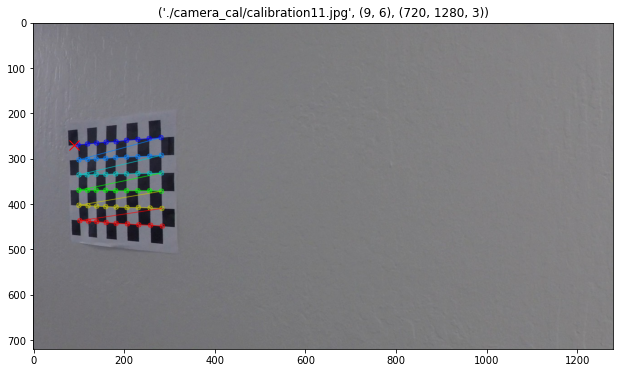

[[ 99.22503 269.60242]
 [119.55949 268.01456]
 [140.10562 266.0964 ]
 [161.33418 264.47052]]


In [6]:
# dev
# one observes that one gets x, y coordinate pairs

path_img = "./camera_cal/calibration11.jpg"
img = load_img(path_img)
img_gray = convert_gray(img)
pattern = (9, 6)
ret, corners = cv2.findChessboardCorners(img, pattern)
img = cv2.drawChessboardCorners(img, pattern, corners, ret)
fig = plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title((path_img, pattern, img.shape))
plt.plot(90, 270, "xr", markersize=10)
plt.show()
print(np.squeeze(corners)[:4])

In [7]:
# setting

PATTERN_SIZE = (9, 6)
IMG_SIZE = (1280, 720)  # also in x, y

In [8]:
@widgets.interact
def show_chessboard(path_img=glob.glob(GLOB_CALIBRATION_IMAGES)):
    img = load_img(path_img)
    img_gray = convert_gray(img)
    ret, corners = cv2.findChessboardCorners(img, pattern)
    if ret:
        img = cv2.drawChessboardCorners(img, pattern, corners, ret)
    else:
        warnings.warn("No matching chessboard pattern found")
    fig = plt.figure(figsize=(12, 6))
    plt.title((path_img, pattern))
    plt.imshow(img)

interactive(children=(Dropdown(description='path_img', options=('./camera_cal\\calibration1.jpg', './camera_ca…

In [9]:
def create_object_points(pattern):
    nx, ny = pattern
    z = 0
    res = np.array([(x, y, z) for y in range(ny) for x in range(nx)])
    return res.astype('float32')

In [10]:
# populate object and image points

object_points = []
image_points = []

for path_img in glob.glob(GLOB_CALIBRATION_IMAGES):
    print(path_img)
    img = load_img(path_img)
    img_gray = convert_gray(img)
    ret, corners = cv2.findChessboardCorners(img, PATTERN_SIZE)
    if ret:
        object_points.append(create_object_points(PATTERN_SIZE))
        image_points.append(corners)
    else:
        print(f"No chessboard pattern found for {path_img}")

./camera_cal\calibration1.jpg
No chessboard pattern found for ./camera_cal\calibration1.jpg
./camera_cal\calibration10.jpg
./camera_cal\calibration11.jpg
./camera_cal\calibration12.jpg
./camera_cal\calibration13.jpg
./camera_cal\calibration14.jpg
./camera_cal\calibration15.jpg
./camera_cal\calibration16.jpg
./camera_cal\calibration17.jpg
./camera_cal\calibration18.jpg
./camera_cal\calibration19.jpg
./camera_cal\calibration2.jpg
./camera_cal\calibration20.jpg
./camera_cal\calibration3.jpg
./camera_cal\calibration4.jpg
No chessboard pattern found for ./camera_cal\calibration4.jpg
./camera_cal\calibration5.jpg
No chessboard pattern found for ./camera_cal\calibration5.jpg
./camera_cal\calibration6.jpg
./camera_cal\calibration7.jpg
./camera_cal\calibration8.jpg
./camera_cal\calibration9.jpg


In [11]:
# # testing image size convention
#
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, (1280, 720), None, None)
# ret1, mtx1, dist1, rvecs1, tvecs1 = cv2.calibrateCamera(object_points, image_points, (720, 1280), None, None)
# np.allclose(mtx, mtx1), np.allclose(dist, dist1)

In [12]:
# fitting process

ret, MTX, DIST, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, IMG_SIZE, None, None)
MTX, DIST

(array([[1.15662906e+03, 0.00000000e+00, 6.69041437e+02],
        [0.00000000e+00, 1.15169194e+03, 3.88137239e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-0.2315715 , -0.12000538, -0.00118338,  0.00023305,  0.15641572]]))

In [13]:
# Create utility function for further usage

def undistort_img(img):
    return cv2.undistort(img, MTX, DIST)

def load_undistort_img(path_img):
    img = load_img(path_img)
    return undistort_img(img)

In [14]:
@widgets.interact
def show_calibration(path_img=glob.glob(GLOB_CALIBRATION_IMAGES)):
    img = load_img(path_img)
    img_undist = undistort_img(img)
    fig = plt.figure(figsize=FIG_SIZE)
    plt.subplot(121)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original")
    plt.subplot(122)
    plt.imshow(img_undist)
    plt.axis('off')
    plt.title("Undistorted")
    plt.tight_layout()

interactive(children=(Dropdown(description='path_img', options=('./camera_cal\\calibration1.jpg', './camera_ca…

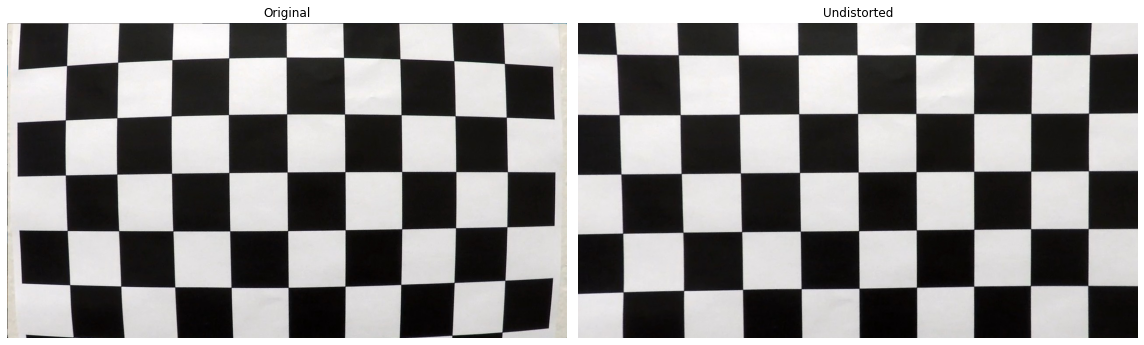

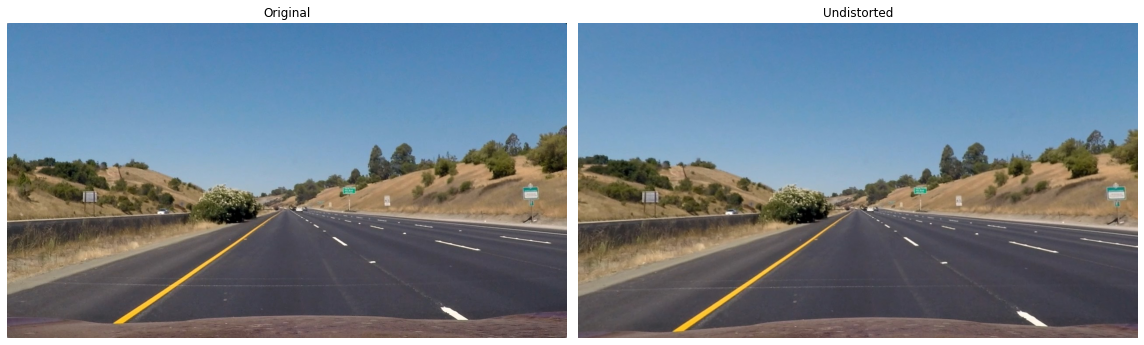

In [15]:
show_calibration("./camera_cal/calibration1.jpg")
plt.savefig(os.path.join(DOC_FOLDER, "undistort_calibration1.jpg"))
plt.show()
show_calibration("./test_images/straight_lines1.jpg")
plt.savefig(os.path.join(DOC_FOLDER, "undistort_straight_lines1.jpg"))
plt.show()

# Perspective Transformation

Task of this section:

* Apply a perspective transform to rectify binary image ("birds-eye view").


## Description

Upon detecting the lane line pixels we want to fit a quadratic polynomial, which further enables us to measure the lane curvature. This is most easily done by looking at the situation from above, which requires a perspective transformation. Perspective transformation can be fitted by supplying appropriate source and destination points.

Note that we want to have a plain view on the road from above. Hence I was mainly focusing on the two ``straight_line*`` images; however also for the other images I was trying to visually check that the lanes are parallel. The source points were taken to be the corner points of the trapezoid forming a straight lane part; its destination points are the top/bottom points with equal x-coordinate, still leaving some space to the left and right side. Those points were picked manually via the interative plotting window. Note the trapezoid is not 100% parallel, most likely the camera is not mounted perfectly at center.

Note, this perspective also determines the pixel-to-real-distance mapping, which I read off in the end. Because of this I also tried to pick as height a clear ending of one of the dashed lines. This is particular hard in the far view.

In [16]:
# # used to interactively search for the best source points
#
# %matplotlib qt
# img = load_undistort_img("./test_images/straight_lines1.jpg")
# img = cv2.line(img, (0, 460), (1280, 460), (255, 0, 0), 1)
# plt.imshow(img)
# plt.show()

In [17]:
SRC_POINTS = [(205, 720), (581, 460), (701, 460), (1107, 720)]
DST_POINTS = [(290, 720), (290, 0), (990, 0), (990, 720)]
SRC_POINTS[1][0] - SRC_POINTS[0][0], SRC_POINTS[3][0] - SRC_POINTS[2][0]

(376, 406)

In [18]:
def fit_perspective_transform(src, dst):
    src = np.asarray(src).reshape(-1, 1, 2).astype(np.float32)
    dst = np.asarray(dst).reshape(-1, 1, 2).astype(np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

M, MINV = fit_perspective_transform(SRC_POINTS, DST_POINTS)

In [19]:
# Create utility function for further usage

def warp_image(img):
    img_size = img.shape[1], img.shape[0]
    return cv2.warpPerspective(img, M, img_size)

def unwarp_image(img):
    img_size = img.shape[1], img.shape[0]
    return cv2.warpPerspective(img, MINV, img_size)

def draw_polylines(img, pts, is_closed=True, color=[255, 0, 0], thickness=2):
    pts = np.asarray(pts).reshape(-1, 1, 2)
    return cv2.polylines(img, [pts], is_closed, color, thickness)

In [20]:
@widgets.interact
def show_perspective(img_path=glob.glob(GLOB_TEST_IMAGES)):
    img = load_undistort_img(img_path)
    img_warp = warp_image(img)
    img = draw_polylines(img, SRC_POINTS)
    img_warp = draw_polylines(img_warp, DST_POINTS)
    fig = plt.figure(figsize=FIG_SIZE)
    plt.subplot(121)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original")
    plt.subplot(122)
    plt.imshow(img_warp)
    plt.axis('off')
    plt.title("Warped")
    plt.tight_layout()

interactive(children=(Dropdown(description='img_path', options=('./test_images\\straight_lines1.jpg', './test_…

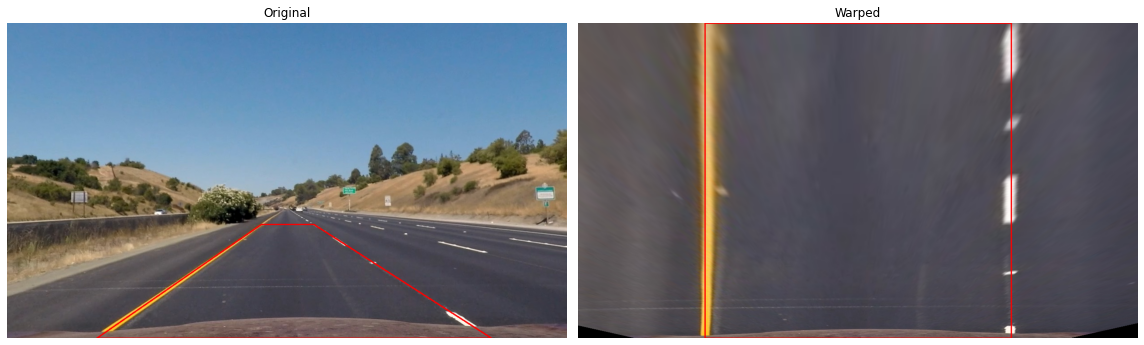

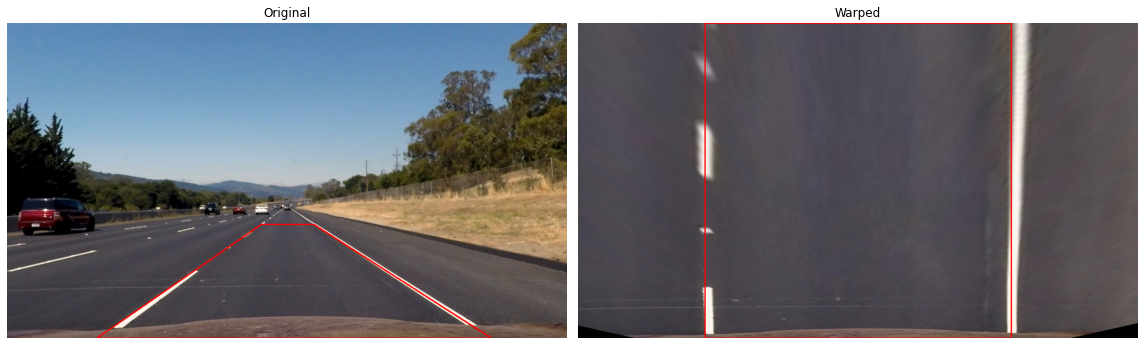

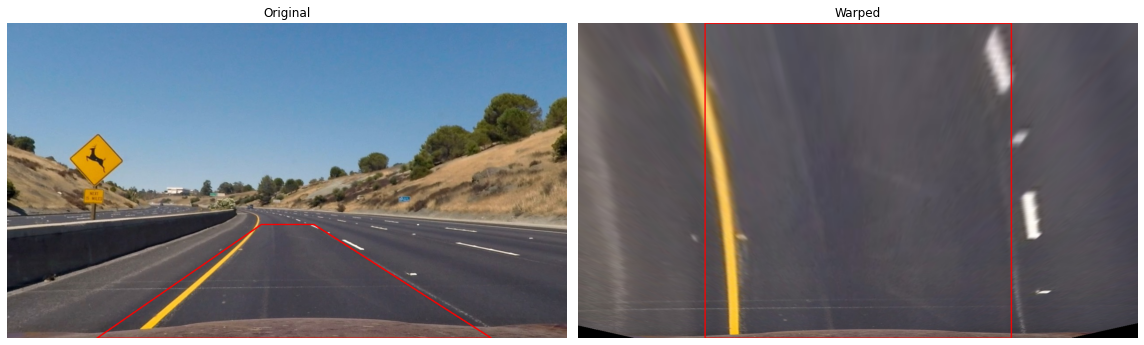

In [21]:
show_perspective("./test_images/straight_lines1.jpg")
plt.savefig(os.path.join(DOC_FOLDER, "perspective_straight_lines1.jpg"))
plt.show()
show_perspective("./test_images/straight_lines2.jpg")
plt.savefig(os.path.join(DOC_FOLDER, "perspective_straight_lines2.jpg"))
plt.show()
show_perspective("./test_images/test2.jpg")
plt.savefig(os.path.join(DOC_FOLDER, "perspective_test2.jpg"))
plt.show()

According to the course material the lane width is 3.7m, while a single dashed lane marker is 3.048m. In particular, from the ``straight_line*`` images one sees that we have about 6 times a dashed line. This gives below units.

In [22]:
XM_PER_PIX = 3.7 / 700
YM_PER_PIX = (6 * 3.048) / 720

# Store
Just store respective data for further, independent usage.

In [23]:
data_store = dict(
    MTX=MTX,
    DIST=DIST,
    SRC_POINTS=SRC_POINTS,
    DST_POINTS=DST_POINTS,
    M=M,
    MINV=MINV,
    XM_PER_PIX=XM_PER_PIX,
    YM_PER_PIX=YM_PER_PIX
)
data_store

{'MTX': array([[1.15662906e+03, 0.00000000e+00, 6.69041437e+02],
        [0.00000000e+00, 1.15169194e+03, 3.88137239e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'DIST': array([[-0.2315715 , -0.12000538, -0.00118338,  0.00023305,  0.15641572]]),
 'SRC_POINTS': [(205, 720), (581, 460), (701, 460), (1107, 720)],
 'DST_POINTS': [(290, 720), (290, 0), (990, 0), (990, 720)],
 'M': array([[-5.53999756e-01, -1.49147693e+00,  9.80411543e+02],
        [-6.16188822e-16, -1.97686594e+00,  9.09358334e+02],
        [-5.86605631e-19, -2.38037258e-03,  1.00000000e+00]]),
 'MINV': array([[ 1.71428571e-01, -7.69065657e-01,  5.31285714e+02],
        [-5.74175948e-17, -5.05851195e-01,  4.60000000e+02],
        [-0.00000000e+00, -1.20411431e-03,  1.00000000e+00]]),
 'XM_PER_PIX': 0.005285714285714286,
 'YM_PER_PIX': 0.0254}

In [24]:
pickle.dump(data_store, open("data_store__part_1.pkl", "wb"))